In [1]:
import numpy as np
import wave
import os
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import random
import math

from numpy import genfromtxt

import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_hub as hub

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

channels = ['F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4']
nchan = len(channels)
#subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21']
subjects = ['01','02','03','06','07','08','09','10']
nsubjects = len(subjects)

procedures = ['resting','stimuli','thinking','speaking']
phonemes = ['goose','thought','zh','p','sh','n','k','fleece','trap','s','ng','t','f','z','m']

In [37]:
#Pull raw subject data out of file
def load_subject_data(subject_name):
    
    data = genfromtxt('FEIS_dataset/experiments/'+subject_name+'/full_eeg.csv', delimiter=',', skip_header = 1,dtype=str)
    return np.delete(data,np.s_[-1:],axis=1) 


#Normalize each channel separately for individual subject
def normalize_subject_data(data):
    
    data_norm = np.copy(data)
    data_norm = np.delete(data_norm,[0,1,-1,-2],1)
    data_norm = data_norm.astype(float)

    normed_rows = np.copy(data_norm)

    for chan in range(len(data_norm.T)):
        mean = np.mean(data_norm.T[chan])
        stdev = np.std(data_norm.T[chan])
        for samp in range(len(data_norm.T[chan])):
            normed_rows.T[chan][samp] = (data_norm.T[chan][samp] - mean) / stdev

    data_norm = normed_rows.astype(str)

    for chan in range(nchan):
        data[:,chan+2] = data_norm[:,chan]
    return data


#Return structured nested data for individual subject
def parse_nested_subject_data(data,procedures,phonemes):
    #Initialize struct for each phone/procedure combo
    struct = [[],[],[],[]] #struct[procedure][phone][epoch][channel]
    for task in range(len(procedures)):
        for phone in phonemes:
            struct[task].append([])

    #Load EEG matrices into struct
    for task in range(len(procedures)):
        for phone in range(len(phonemes)):

            epoch_ct = 0
            epoch_index = 0
            struct[task][phone].append([])
            for i in range(len(data)):
                if data[i][-2] == phonemes[phone] and data[i][-1] == procedures[task]:
                    if float(data[i][1]) > epoch_ct:
                        struct[task][phone].append([data[i][0:16]])
                        epoch_ct = float(data[i][1])
                        epoch_index += 1
                    else:
                        struct[task][phone][epoch_index].append(data[i][0:16])
        print("task:",task)

    for task in range(len(procedures)):
        for phone in range(len(phonemes)):
            if struct[task][phone][0] == []:
                del struct[task][phone][0]   
    return struct


#returns audio time series
def extract_audio(fname):
    input_data = read(fname)
    audio = input_data[1]
    plt.plot(audio[0:len(audio)])
    return audio


#returns start and end time of significant sound in audio file
def isolate_sound(audio):
    start = 0
    end = 0
    start_found = False
    for frame in range(len(audio)):
        if audio[frame] > 100:
            end = frame
            if not start_found:
                start = frame
                start_found = True
    start_time = start/len(audio)
    end_time = end/len(audio)
    return start_time, end_time


#Determine windows within audio files when individual subject was sounding for each phoneme
def isolate_sound_batch(subject_name):
    
    wav_time_dict = {} #Tuples to start and end times indexed by wav audio file name
    file_names = os.listdir('FEIS_dataset/wavs/'+subject_name+'/wavs')
    for fname in file_names:
        print(fname)
        audio = extract_audio('FEIS_dataset/wavs/'+subject_name+'/wavs/'+fname)
        wav_time_dict[fname] = (isolate_sound(audio))

    return wav_time_dict


#Separates EEG samples from within the audio time window for indiv subject, 1 task, all phonemes
def isolate_eeg_sounds(task, phonemes, wav_time_dict):
    
    n100 = 0.07 #N100 occurs 80ms after stim onset, as first indication of stimuli presentation (listen/view)
    timed_feats_all_phonemes = []
    for phone in range(len(phonemes)):
    
        wav_start,wav_end = wav_time_dict[phonemes[phone]+'.wav'] #Start/End of phoneme in wav audio clip

        timed_features = [] #Contains groups of all continous sounds
        for epoch in struct[task][phone]:
            sound_packet = [] #1 continous sound (not whole 5 seconds of repetition)
            init_repetition = int(float(epoch[0][0]))
            repetition = init_repetition
            for sample in epoch:

                #Determines if EEG sample is in the audio window
                sample_formatted = float('0.' + sample[0].split('.')[1])
                if sample_formatted > (wav_start + n100) and sample_formatted < wav_end:
                    if int(float(sample[0])) == repetition:
                        sound_packet.append(sample)
                    else:
                        repetition = int(float(sample[0]))
                        timed_features.append(sound_packet.copy())
                        sound_packet = []
                        
            timed_features.append(sound_packet.copy()) #Each appended packet is a single sound
        timed_feats_all_phonemes.append(timed_features)
    return timed_feats_all_phonemes


#Makes sample windows for 1 subject, 1 task, all phonemes
def construct_windowed_dataset(timed_feats, phonemes, window_size=13):
    
    #window_size = 13 => 0.0507 second samples = 51ms < L_phoneme
    offset=13
    
    #Construct dataset with samples of sliding window for each phoneme
    phoneme_datasets = []

    for phone in range(len(phonemes)):
        ds = []
        for sound_packet in timed_feats[phone]:
            ind_max = len(sound_packet)
            start = 0
            end = window_size
            while ind_max > end:
                ds.append(sound_packet[start:end])
                start += offset
                end += offset
        phoneme_datasets.append(ds)
        
    structured_dataset = []
    for phone_ds in phoneme_datasets:
        temp_phone = []
        for sound_packet in phone_ds:
            temp_packet = []
            for timepoint in sound_packet:
                temp_packet.append(timepoint[2:])
            temp_phone.append(temp_packet)
        structured_dataset.append(np.asarray(temp_phone).astype(float))
    
    return structured_dataset


#Split data into training and validation sets
def split_data(x,t,training_size=0.8): #x=phoneme[i], t=target phoneme label

    #Identifies indices to split data by
    data_index = np.arange(len(t))
    random.shuffle(data_index)
    training_index = data_index[:int(training_size*len(t))]
    testing_index = data_index[int(training_size*len(t)):]

    training_x = []
    training_t = []
    for index in training_index:
        training_x.append(x[index])
        training_t.append(t[index])

    testing_x = []
    testing_t = []
    for index in testing_index:
        testing_x.append(x[index])
        testing_t.append(t[index])
        
    training_x = np.asarray(training_x)
    training_t = np.asarray(training_t)
    testing_x = np.asarray(testing_x)
    testing_t = np.asarray(testing_t)
    
    return training_x,training_t,testing_x,testing_t


def eval_model(training_x,training_t,testing_x,testing_t):

    train_loss, train_acc = model.evaluate(training_x,  training_t, verbose=2)
    print('Train accuracy:', train_acc)
    print()

    test_loss, test_acc = model.evaluate(testing_x,  testing_t, verbose=2)
    print('Test accuracy:', test_acc)
    

#Stack data so it can be shuffled for determining validation and testing sets
def indiv_val_ds(structured_dataset):
    
    x = [] #datapoints
    t = [] #labels
    for phone in range(len(structured_dataset)):
        for sound_packet in structured_dataset[phone]:
            x.append(sound_packet)
            t.append(phone)
    
    training_x,training_t,testing_x,testing_t = split_data(x,t)

    return training_x,training_t,testing_x,testing_t

def train_MLP(training_x,training_t,testing_x,testing_t):
    
    input_shape = (training_x.shape[1:])
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(input_shape)),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000005)
    
    history = model.fit(training_x, training_t, epochs=150)
    test_loss, test_acc = model.evaluate(testing_x,  testing_t, verbose=2)
    
    return history, test_acc

task: 0
task: 1
task: 2
task: 3
thought.wav
k.wav
zh.wav
n.wav
fleece.wav
trap.wav
m.wav
z.wav
v.wav
t.wav
f.wav
p.wav
ng.wav
s.wav
goose.wav
sh.wav
Epoch 1/150
114/114 [==============================] - 4s 32ms/step - loss: 2.7035 - accuracy: 0.0815
Epoch 2/150
114/114 [==============================] - 4s 33ms/step - loss: 2.6797 - accuracy: 0.1366
Epoch 3/150
114/114 [==============================] - 4s 32ms/step - loss: 2.6443 - accuracy: 0.1405
Epoch 4/150
114/114 [==============================] - 4s 33ms/step - loss: 2.6060 - accuracy: 0.1392
Epoch 5/150
114/114 [==============================] - 4s 35ms/step - loss: 2.5741 - accuracy: 0.1654
Epoch 6/150
114/114 [==============================] - 4s 34ms/step - loss: 2.5251 - accuracy: 0.1893
Epoch 7/150
114/114 [==============================] - 4s 35ms/step - loss: 2.4758 - accuracy: 0.2246
Epoch 8/150
114/114 [==============================] - 4s 33ms/step - loss: 2.4197 - accuracy: 0.2333
Epoch 9/150
114/114 [==============

114/114 [==============================] - 4s 31ms/step - loss: 0.1098 - accuracy: 0.9870
Epoch 80/150
114/114 [==============================] - 4s 34ms/step - loss: 0.0942 - accuracy: 0.9896
Epoch 81/150
114/114 [==============================] - 4s 34ms/step - loss: 0.0865 - accuracy: 0.9935
Epoch 82/150
114/114 [==============================] - 4s 35ms/step - loss: 0.0850 - accuracy: 0.9921
Epoch 83/150
114/114 [==============================] - 4s 34ms/step - loss: 0.0767 - accuracy: 0.9937
Epoch 84/150
114/114 [==============================] - 4s 32ms/step - loss: 0.0635 - accuracy: 0.9965
Epoch 85/150
114/114 [==============================] - 4s 31ms/step - loss: 0.0626 - accuracy: 0.9974
Epoch 86/150
114/114 [==============================] - 4s 31ms/step - loss: 0.0541 - accuracy: 0.9984
Epoch 87/150
114/114 [==============================] - 4s 31ms/step - loss: 0.0518 - accuracy: 0.9985
Epoch 88/150
114/114 [==============================] - 4s 33ms/step - loss: 0.0461 - 

143/143 [==============================] - 5s 35ms/step - loss: 2.6051 - accuracy: 0.1266
Epoch 6/150
143/143 [==============================] - 5s 34ms/step - loss: 2.5832 - accuracy: 0.1378
Epoch 7/150
143/143 [==============================] - 5s 34ms/step - loss: 2.5716 - accuracy: 0.1290
Epoch 8/150
143/143 [==============================] - 5s 36ms/step - loss: 2.5294 - accuracy: 0.1582
Epoch 9/150
143/143 [==============================] - 5s 35ms/step - loss: 2.5017 - accuracy: 0.1783
Epoch 10/150
143/143 [==============================] - 5s 36ms/step - loss: 2.4502 - accuracy: 0.2003
Epoch 11/150
143/143 [==============================] - 5s 36ms/step - loss: 2.4158 - accuracy: 0.2218
Epoch 12/150
143/143 [==============================] - 5s 35ms/step - loss: 2.3767 - accuracy: 0.2454
Epoch 13/150
143/143 [==============================] - 5s 38ms/step - loss: 2.3365 - accuracy: 0.2589
Epoch 14/150
143/143 [==============================] - 5s 34ms/step - loss: 2.3024 - accu

143/143 [==============================] - 5s 36ms/step - loss: 0.3682 - accuracy: 0.9150
Epoch 85/150
143/143 [==============================] - 5s 34ms/step - loss: 0.3216 - accuracy: 0.9323
Epoch 86/150
143/143 [==============================] - 6s 39ms/step - loss: 0.2902 - accuracy: 0.9458
Epoch 87/150
143/143 [==============================] - 6s 41ms/step - loss: 0.2871 - accuracy: 0.9441
Epoch 88/150
143/143 [==============================] - 5s 38ms/step - loss: 0.2823 - accuracy: 0.9471
Epoch 89/150
143/143 [==============================] - 5s 38ms/step - loss: 0.2725 - accuracy: 0.9489
Epoch 90/150
143/143 [==============================] - 5s 34ms/step - loss: 0.2453 - accuracy: 0.9577
Epoch 91/150
143/143 [==============================] - 5s 36ms/step - loss: 0.2298 - accuracy: 0.9622
Epoch 92/150
143/143 [==============================] - 5s 35ms/step - loss: 0.2180 - accuracy: 0.9605
Epoch 93/150
143/143 [==============================] - 5s 34ms/step - loss: 0.2031 - 

Epoch 11/150
122/122 [==============================] - 4s 31ms/step - loss: 2.3539 - accuracy: 0.2523
Epoch 12/150
122/122 [==============================] - 4s 32ms/step - loss: 2.3354 - accuracy: 0.2589
Epoch 13/150
122/122 [==============================] - 4s 32ms/step - loss: 2.2813 - accuracy: 0.2827
Epoch 14/150
122/122 [==============================] - 4s 33ms/step - loss: 2.2642 - accuracy: 0.2809
Epoch 15/150
122/122 [==============================] - 4s 31ms/step - loss: 2.2270 - accuracy: 0.2994
Epoch 16/150
122/122 [==============================] - 4s 34ms/step - loss: 2.1701 - accuracy: 0.3273
Epoch 17/150
122/122 [==============================] - 4s 34ms/step - loss: 2.1403 - accuracy: 0.3537
Epoch 18/150
122/122 [==============================] - 4s 33ms/step - loss: 2.0875 - accuracy: 0.3538
Epoch 19/150
122/122 [==============================] - 4s 32ms/step - loss: 2.0549 - accuracy: 0.3666
Epoch 20/150
122/122 [==============================] - 4s 34ms/step - lo

122/122 [==============================] - 4s 31ms/step - loss: 0.3169 - accuracy: 0.9415
Epoch 91/150
122/122 [==============================] - 4s 31ms/step - loss: 0.3355 - accuracy: 0.9353
Epoch 92/150
122/122 [==============================] - 4s 31ms/step - loss: 0.3030 - accuracy: 0.9460
Epoch 93/150
122/122 [==============================] - 4s 31ms/step - loss: 0.3239 - accuracy: 0.9305
Epoch 94/150
122/122 [==============================] - 4s 31ms/step - loss: 0.2752 - accuracy: 0.9464
Epoch 95/150
122/122 [==============================] - 4s 31ms/step - loss: 0.2845 - accuracy: 0.9466
Epoch 96/150
122/122 [==============================] - 4s 31ms/step - loss: 0.2552 - accuracy: 0.9544
Epoch 97/150
122/122 [==============================] - 4s 31ms/step - loss: 0.2575 - accuracy: 0.9528
Epoch 98/150
122/122 [==============================] - 4s 31ms/step - loss: 0.2596 - accuracy: 0.9493
Epoch 99/150
122/122 [==============================] - 4s 31ms/step - loss: 0.2349 - 

147/147 [==============================] - 5s 31ms/step - loss: 2.1187 - accuracy: 0.3458
Epoch 17/150
147/147 [==============================] - 5s 31ms/step - loss: 2.0590 - accuracy: 0.3664
Epoch 18/150
147/147 [==============================] - 5s 31ms/step - loss: 2.0286 - accuracy: 0.3821
Epoch 19/150
147/147 [==============================] - 5s 31ms/step - loss: 1.9609 - accuracy: 0.3984
Epoch 20/150
147/147 [==============================] - 5s 31ms/step - loss: 1.9449 - accuracy: 0.4077
Epoch 21/150
147/147 [==============================] - 5s 31ms/step - loss: 1.9025 - accuracy: 0.4123
Epoch 22/150
147/147 [==============================] - 5s 31ms/step - loss: 1.8226 - accuracy: 0.4436
Epoch 23/150
147/147 [==============================] - 5s 31ms/step - loss: 1.7903 - accuracy: 0.4464
Epoch 24/150
147/147 [==============================] - 5s 31ms/step - loss: 1.7566 - accuracy: 0.4555
Epoch 25/150
147/147 [==============================] - 5s 32ms/step - loss: 1.7332 - 

147/147 [==============================] - 5s 31ms/step - loss: 0.0556 - accuracy: 0.9994
Epoch 96/150
147/147 [==============================] - 5s 32ms/step - loss: 0.0575 - accuracy: 0.9988
Epoch 97/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0494 - accuracy: 1.0000
Epoch 98/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0483 - accuracy: 0.9988
Epoch 99/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0433 - accuracy: 1.0000
Epoch 100/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0411 - accuracy: 1.0000
Epoch 101/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0417 - accuracy: 1.0000
Epoch 102/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0371 - accuracy: 1.0000
Epoch 103/150
147/147 [==============================] - 5s 31ms/step - loss: 0.0337 - accuracy: 0.9997
Epoch 104/150
147/147 [==============================] - 5s 31ms/step - loss: 0.03

256/256 [==============================] - 8s 31ms/step - loss: 1.9226 - accuracy: 0.3853
Epoch 22/150
256/256 [==============================] - 8s 31ms/step - loss: 1.8915 - accuracy: 0.3885
Epoch 23/150
256/256 [==============================] - 8s 31ms/step - loss: 1.8746 - accuracy: 0.3970
Epoch 24/150
256/256 [==============================] - 8s 31ms/step - loss: 1.8156 - accuracy: 0.4143
Epoch 25/150
256/256 [==============================] - 8s 32ms/step - loss: 1.7945 - accuracy: 0.4333
Epoch 26/150
256/256 [==============================] - 8s 31ms/step - loss: 1.7728 - accuracy: 0.4313
Epoch 27/150
256/256 [==============================] - 8s 30ms/step - loss: 1.7239 - accuracy: 0.4553
Epoch 28/150
256/256 [==============================] - 8s 31ms/step - loss: 1.7038 - accuracy: 0.4618
Epoch 29/150
256/256 [==============================] - 8s 31ms/step - loss: 1.6482 - accuracy: 0.4806
Epoch 30/150
256/256 [==============================] - 8s 31ms/step - loss: 1.6146 - 

256/256 [==============================] - 8s 31ms/step - loss: 0.0761 - accuracy: 0.9948
Epoch 101/150
256/256 [==============================] - 8s 31ms/step - loss: 0.1210 - accuracy: 0.9823
Epoch 102/150
256/256 [==============================] - 8s 31ms/step - loss: 0.2238 - accuracy: 0.9420
Epoch 103/150
256/256 [==============================] - 8s 31ms/step - loss: 0.0805 - accuracy: 0.9921
Epoch 104/150
256/256 [==============================] - 8s 31ms/step - loss: 0.0641 - accuracy: 0.9964
Epoch 105/150
256/256 [==============================] - 8s 31ms/step - loss: 0.0580 - accuracy: 0.9979
Epoch 106/150
256/256 [==============================] - 8s 31ms/step - loss: 0.0559 - accuracy: 0.9979
Epoch 107/150
256/256 [==============================] - 8s 31ms/step - loss: 0.0510 - accuracy: 0.9981
Epoch 108/150
256/256 [==============================] - 8s 31ms/step - loss: 0.0480 - accuracy: 0.9986
Epoch 109/150
256/256 [==============================] - 8s 31ms/step - loss: 

Epoch 27/150
118/118 [==============================] - 4s 31ms/step - loss: 1.6910 - accuracy: 0.4678
Epoch 28/150
118/118 [==============================] - 4s 31ms/step - loss: 1.6940 - accuracy: 0.4743
Epoch 29/150
118/118 [==============================] - 4s 31ms/step - loss: 1.6709 - accuracy: 0.4714
Epoch 30/150
118/118 [==============================] - 4s 31ms/step - loss: 1.6269 - accuracy: 0.4957
Epoch 31/150
118/118 [==============================] - 4s 31ms/step - loss: 1.5927 - accuracy: 0.5073
Epoch 32/150
118/118 [==============================] - 4s 31ms/step - loss: 1.5344 - accuracy: 0.5189
Epoch 33/150
118/118 [==============================] - 4s 32ms/step - loss: 1.5060 - accuracy: 0.5338
Epoch 34/150
118/118 [==============================] - 4s 31ms/step - loss: 1.4627 - accuracy: 0.5443
Epoch 35/150
118/118 [==============================] - 4s 31ms/step - loss: 1.4332 - accuracy: 0.5592
Epoch 36/150
118/118 [==============================] - 4s 32ms/step - lo

118/118 [==============================] - 4s 31ms/step - loss: 0.0482 - accuracy: 0.9971
Epoch 107/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0463 - accuracy: 0.9988
Epoch 108/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0440 - accuracy: 0.9993
Epoch 109/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0392 - accuracy: 0.9984
Epoch 110/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0363 - accuracy: 0.9997
Epoch 111/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0356 - accuracy: 0.9985
Epoch 112/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0303 - accuracy: 1.0000
Epoch 113/150
118/118 [==============================] - 4s 32ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 114/150
118/118 [==============================] - 4s 31ms/step - loss: 0.0270 - accuracy: 1.0000
Epoch 115/150
118/118 [==============================] - 4s 31ms/step - loss: 

54/54 [==============================] - 2s 31ms/step - loss: 1.9504 - accuracy: 0.4029
Epoch 34/150
54/54 [==============================] - 2s 38ms/step - loss: 1.9218 - accuracy: 0.4254
Epoch 35/150
54/54 [==============================] - 2s 38ms/step - loss: 1.9174 - accuracy: 0.4296
Epoch 36/150
54/54 [==============================] - 2s 43ms/step - loss: 1.8351 - accuracy: 0.4556
Epoch 37/150
54/54 [==============================] - 2s 42ms/step - loss: 1.8227 - accuracy: 0.4595
Epoch 38/150
54/54 [==============================] - 3s 50ms/step - loss: 1.8706 - accuracy: 0.4272
Epoch 39/150
54/54 [==============================] - 2s 41ms/step - loss: 1.7924 - accuracy: 0.4763
Epoch 40/150
54/54 [==============================] - 2s 38ms/step - loss: 1.7764 - accuracy: 0.4866
Epoch 41/150
54/54 [==============================] - 2s 42ms/step - loss: 1.7696 - accuracy: 0.4563
Epoch 42/150
54/54 [==============================] - 2s 37ms/step - loss: 1.7184 - accuracy: 0.4682
Epo

54/54 [==============================] - 3s 64ms/step - loss: 0.3138 - accuracy: 0.9466
Epoch 114/150
54/54 [==============================] - 3s 64ms/step - loss: 0.2728 - accuracy: 0.9572
Epoch 115/150
54/54 [==============================] - 4s 65ms/step - loss: 0.3218 - accuracy: 0.9414
Epoch 116/150
54/54 [==============================] - 4s 65ms/step - loss: 0.3720 - accuracy: 0.9172
Epoch 117/150
54/54 [==============================] - 4s 66ms/step - loss: 0.2899 - accuracy: 0.9489
Epoch 118/150
54/54 [==============================] - 4s 65ms/step - loss: 0.2663 - accuracy: 0.9531
Epoch 119/150
54/54 [==============================] - 4s 65ms/step - loss: 0.2473 - accuracy: 0.9655
Epoch 120/150
54/54 [==============================] - 4s 65ms/step - loss: 0.2509 - accuracy: 0.9523
Epoch 121/150
54/54 [==============================] - 4s 65ms/step - loss: 0.2579 - accuracy: 0.9526
Epoch 122/150
54/54 [==============================] - 4s 67ms/step - loss: 0.2475 - accuracy: 0

59/59 [==============================] - 4s 70ms/step - loss: 1.7930 - accuracy: 0.3924
Epoch 42/150
59/59 [==============================] - 4s 75ms/step - loss: 1.7802 - accuracy: 0.4118
Epoch 43/150
59/59 [==============================] - 4s 63ms/step - loss: 1.7181 - accuracy: 0.4380
Epoch 44/150
59/59 [==============================] - 3s 45ms/step - loss: 1.7191 - accuracy: 0.4228
Epoch 45/150
59/59 [==============================] - 2s 34ms/step - loss: 1.6973 - accuracy: 0.4187
Epoch 46/150
59/59 [==============================] - 2s 39ms/step - loss: 1.6802 - accuracy: 0.4365
Epoch 47/150
59/59 [==============================] - 2s 33ms/step - loss: 1.6559 - accuracy: 0.4588
Epoch 48/150
59/59 [==============================] - 2s 36ms/step - loss: 1.6349 - accuracy: 0.4554
Epoch 49/150
59/59 [==============================] - 2s 36ms/step - loss: 1.6136 - accuracy: 0.4583
Epoch 50/150
59/59 [==============================] - 2s 33ms/step - loss: 1.5857 - accuracy: 0.4744
Epo

59/59 [==============================] - 2s 32ms/step - loss: 0.2407 - accuracy: 0.9608
Epoch 123/150
59/59 [==============================] - 2s 31ms/step - loss: 0.2263 - accuracy: 0.9660
Epoch 124/150
59/59 [==============================] - 2s 31ms/step - loss: 0.2060 - accuracy: 0.9696
Epoch 125/150
59/59 [==============================] - 2s 31ms/step - loss: 0.2143 - accuracy: 0.9690
Epoch 126/150
59/59 [==============================] - 2s 31ms/step - loss: 0.2038 - accuracy: 0.9707
Epoch 127/150
59/59 [==============================] - 2s 31ms/step - loss: 0.1685 - accuracy: 0.9833
Epoch 128/150
59/59 [==============================] - 2s 31ms/step - loss: 0.1617 - accuracy: 0.9871
Epoch 129/150
59/59 [==============================] - 2s 31ms/step - loss: 0.1620 - accuracy: 0.9866
Epoch 130/150
59/59 [==============================] - 2s 32ms/step - loss: 0.1420 - accuracy: 0.9876
Epoch 131/150
59/59 [==============================] - 2s 31ms/step - loss: 0.1458 - accuracy: 0

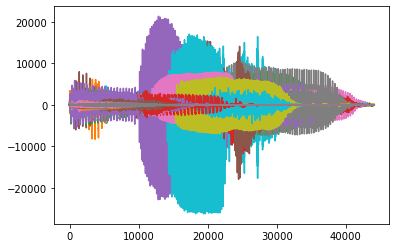

In [3]:
all_subjects_data = []
all_subjects_structured_data = []
all_subjects_history = []
all_subjects_test_acc = []
task = 1 #Listening

for subject_name in subjects:
    
    data = load_subject_data(subject_name)
    data_norm = normalize_subject_data(data)
    struct = parse_nested_subject_data(data_norm,procedures,phonemes)
    
    wav_time_dict = isolate_sound_batch(subject_name)
    timed_feats_all_phonemes = isolate_eeg_sounds(task, phonemes, wav_time_dict)
    structured_dataset = construct_windowed_dataset(timed_feats_all_phonemes, phonemes, window_size=13)
    
    training_x,training_t,testing_x,testing_t = indiv_val_ds(structured_dataset)
    history, test_acc = train_MLP(training_x,training_t,testing_x,testing_t)
    print("Subject:",subject_name,' - Accuracy:',test_acc)
    
    all_subjects_data.append(data)
    all_subjects_structured_data.append(structured_dataset)
    all_subjects_history.append(history)
    all_subjects_test_acc.append(test_acc)

In [13]:
print(np.asarray(all_subjects_test_acc).std())

0.10210475602905464


In [10]:
for subj in range(len(subjects)):
    print("Subject",subjects[subj],' - Test Accuracy:',all_subjects_test_acc[subj])

Subject 01  - Test Accuracy: 0.5767543911933899
Subject 02  - Test Accuracy: 0.3222416937351227
Subject 03  - Test Accuracy: 0.4303278625011444
Subject 06  - Test Accuracy: 0.27303755283355713
Subject 07  - Test Accuracy: 0.3845401108264923
Subject 08  - Test Accuracy: 0.23354564607143402
Subject 09  - Test Accuracy: 0.30787035822868347
Subject 10  - Test Accuracy: 0.30084747076034546


In [24]:
print(len(all_subjects_structured_data)) #nSubjects
print(len(all_subjects_structured_data[0])) #nPhonemes
print(len(all_subjects_structured_data[0][0])) #Number of sound packets
print(len(all_subjects_structured_data[0][0][0])) #Number of timepoints/sound packet
print(len(all_subjects_structured_data[0][0][0][0])) #Number of channels

8
15
310
13
14


In [28]:
x = []
t = []

for subject in all_subjects_structured_data:
    for phone in range(len(subject)):
        for sound_packet in subject[phone]:
            x.append(sound_packet)
            t.append(phone)
            
training_x,training_t,testing_x,testing_t = split_data(x,t)
print("Training Size:",len(training_x))
print("Testing Size:",len(testing_x))

Training Size: 32368
Testing Size: 8092


In [34]:
input_shape = (training_x.shape[1:])
    
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_shape)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000025)

history = model.fit(training_x, training_t, epochs=50)
test_loss, test_acc = model.evaluate(testing_x,  testing_t, verbose=2)

Epoch 1/50
1012/1012 [==============================] - 37s 36ms/step - loss: 2.6846 - accuracy: 0.0786
Epoch 2/50
1012/1012 [==============================] - 37s 36ms/step - loss: 2.6226 - accuracy: 0.1240
Epoch 3/50
1012/1012 [==============================] - 34s 34ms/step - loss: 2.5070 - accuracy: 0.1772
Epoch 4/50
1012/1012 [==============================] - 48s 47ms/step - loss: 2.3708 - accuracy: 0.2337
Epoch 5/50
1012/1012 [==============================] - 36s 35ms/step - loss: 2.2055 - accuracy: 0.2901
Epoch 6/50
1012/1012 [==============================] - 34s 34ms/step - loss: 2.0321 - accuracy: 0.3561
Epoch 7/50
1012/1012 [==============================] - 38s 38ms/step - loss: 1.8559 - accuracy: 0.4171
Epoch 8/50
1012/1012 [==============================] - 36s 35ms/step - loss: 1.6417 - accuracy: 0.4887
Epoch 9/50
1012/1012 [==============================] - 32s 32ms/step - loss: 1.4394 - accuracy: 0.5543
Epoch 10/50
1012/1012 [==============================] - 32s 32m

In [33]:
test_acc

0.3318091928958893

In [36]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 182)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 1000)              183000    
_________________________________________________________________
dense_122 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_123 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_124 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_125 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_126 (Dense)            (None, 1000)            

In [38]:
eval_model(training_x,training_t,testing_x,testing_t)

1012/1012 - 9s - loss: 0.0726 - accuracy: 0.9776
Train accuracy: 0.9776013493537903

253/253 - 2s - loss: 4.9455 - accuracy: 0.3773
Test accuracy: 0.3772861957550049


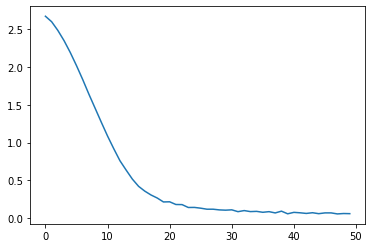

In [39]:
plt.plot(history.history['loss'])

In [40]:
1/15

0.06666666666666667